In [1]:
from util.pred import wsi_predictor
from cfg import *
import matplotlib.pyplot as plt
from util.processor import *
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (14,10)

Segmentation Models: using `keras` framework.


In [2]:
NERVE_MODEL_PATH = './model/nerve_100_unet_efficientnetb0_imagenet_10022.hdf5'
TUMOR_MODEL_PATH = './model/tumor_100_deeplab_xception_pascal_voc_0927.hdf5'

NERVE_MODEL = NERVE_MODEL_PATH.split('/')[-1].split('_')[2]
TUMOR_MODEL = TUMOR_MODEL_PATH.split('/')[-1].split('_')[2]
NERVE_MAG = NERVE_MODEL_PATH.split('/')[-1].split('_')[1]
TUMOR_MAG = TUMOR_MODEL_PATH.split('/')[-1].split('_')[1]
NERVE_BACKBONE = NERVE_MODEL_PATH.split('/')[-1].split('_')[3]
TUMOR_BACKBONE = TUMOR_MODEL_PATH.split('/')[-1].split('_')[3]
if NERVE_MODEL=='deeplab':
    NERVE_WEIGHT='pascal_voc'
else:
    NERVE_WEIGHT = NERVE_MODEL_PATH.split('/')[-1].split('_')[4]
if TUMOR_MODEL=='deeplab':
    TUMOR_WEIGHT='pascal_voc'
else:
    TUMOR_WEIGHT = TUMOR_MODEL_PATH.split('/')[-1].split('_')[4]
init_params = {
    'NERVE_MODEL':NERVE_MODEL,
    'NERVE_MODEL_PATH':NERVE_MODEL_PATH,
    'TUMOR_MODEL':TUMOR_MODEL,
    'TUMOR_MODEL_PATH':TUMOR_MODEL_PATH,
    'NERVE_BACKBONE':NERVE_BACKBONE,
    'TUMOR_BACKBONE':TUMOR_BACKBONE,
    'NERVE_WEIGHT':NERVE_WEIGHT,
    'TUMOR_WEIGHT':TUMOR_WEIGHT,
    'NERVE_MAG':int(NERVE_MAG),
    'TUMOR_MAG':int(TUMOR_MAG)
}

In [3]:
wsi_p = wsi_predictor(init_params)

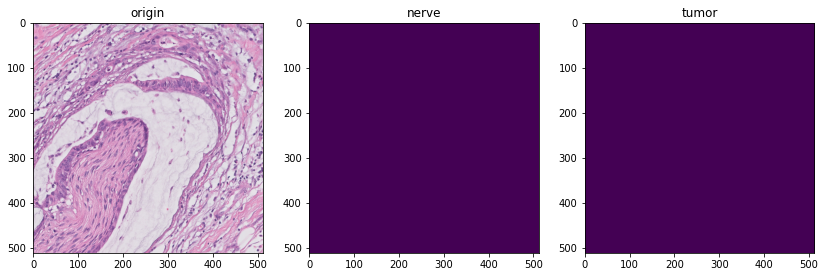

In [4]:
'/data/colon/IS/S16-2273/patch_100_5/mask/'
sample_patch = cv.imread('/data/colon/IS/S16-2273/patch_100_5/image/s16-2273-a5_he_20210802_121327_1.png') # p3
#sample_patch = cv.imread('/data/colon/IS/S14-5675/patch_50_5/image/s14-5675-a5_he_20210730_123932_41.png') # p2




a,b = wsi_p.predict_patch(sample_patch)
plt.figure()
plt.subplot(1,3,1); plt.title('origin'); plt.imshow(sample_patch)
plt.subplot(1,3,2); plt.title('nerve');plt.imshow(a)
plt.subplot(1,3,3); plt.title('tumor');plt.imshow(b)

In [8]:
test_slide = TEST_SLIDE_PATHS[3]
test_anno = test_slide[:-4] + 'xml'
level = 4
print(test_slide,test_anno,level)

slide = slide_processor({
    'slide_path':test_slide,
    'xml_path':test_anno,
    'level':level,
    'patch_size':512,
    'patch_name':'patch100'
})

x = slide.get_annotation_dict()
## Show Tumor BBOX
for k in x['bboxes'].keys():
    print(f'{k} : {len(x["bboxes"][k])}')
    
    

/data/colon/IS/S17-6609/s17-6609-a2_he_20210803_173533.tiff /data/colon/IS/S17-6609/s17-6609-a2_he_20210803_173533.xml 4
p2 : 2
p1 : 4
p3 : 1


In [9]:
msk, prt = wsi_p.predict_regions(test_slide,test_anno,overlap=0.0,dilate_iter=2,level = level,kernel_size = 4)

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


In [10]:
cv.imwrite('/data/colon/IS/S14-327/bin_nonover_nerve100_uneteff0_tumor_100_deeplab.jpg',prt)

True

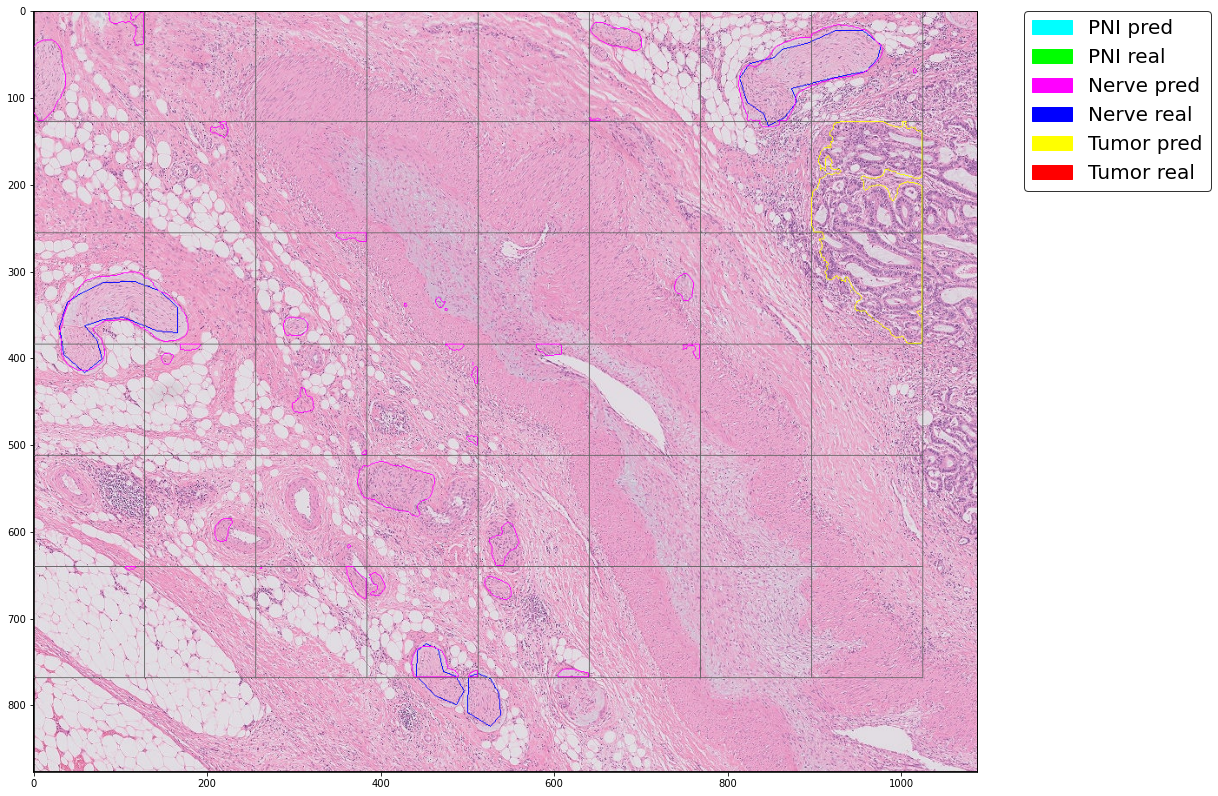

In [11]:
bbox = x['bboxes']['p2'][1]
min_x,min_y = np.min(bbox,axis=0)
max_x,max_y = np.max(bbox,axis=0)
plt.figure(figsize = (18,14))
plt.imshow(prt[min_y:max_y,min_x:max_x])

# Legend
pni_pred_c   = mpatches.Patch(edgecolor = (0,1,1,1),facecolor= (0,1,1,1), label = 'PNI pred'); 
pni_real_c   = mpatches.Patch(edgecolor = (0,1,0,1),facecolor= (0,1,0,1), label = 'PNI real')
nerve_pred_c = mpatches.Patch(edgecolor = (1,0,1,1),facecolor= (1,0,1,1), label = 'Nerve pred'); 
nerve_real_c = mpatches.Patch(edgecolor = (0,0,1,1),facecolor= (0,0,1,1), label = 'Nerve real')
tumor_pred_c = mpatches.Patch(edgecolor = (1,1,0,1),facecolor= (1,1,0,1), label = 'Tumor pred');
tumor_real_c = mpatches.Patch(edgecolor = (1,0,0,1),facecolor= (1,0,0,1), label = 'Tumor real')
legends = [pni_pred_c,pni_real_c,nerve_pred_c,nerve_real_c,tumor_pred_c,tumor_real_c]


plt.legend(handles=legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20 ,edgecolor='inherit')

----

In [12]:
import os
tp = 0; fp = 0; fn =0; tn = 0; level = 4; idx = 0
for slide_path in TEST_SLIDE_PATHS:
    xml_path = slide_path.split('.')[0] + '.xml'
    if os.path.exists(xml_path):
        cfm = wsi_p.eval_regions(slide_path,xml_path,overlap=0.0,dilate_iter=2,level = level,kernel_size = 4)
        tp+=cfm[0]; fp+= cfm[1]; fn+= cfm[2]; tn+=cfm[3]
    else:
        continue
    idx+=1
    print(idx)
    
print(f'\nTrue Positive : {tp}\nFalse Positive : {fp}\nFalse Negative : {fn}\nTrue Negative : {tn} ')

100%|██████████| 3/3 [00:05<00:00,  1.86s/it]



True Positive : 8
False Positive : 9
False Negative : 2
True Negative : 38 


In [13]:
import seaborn as sns

In [14]:
np.array([[tp,fp],[fn,tn]])

array([[ 8,  9],
       [ 2, 38]])

In [15]:
sns.set_context(font_scale=2)

Accuracy : 0.807
Precision(PPV) : 0.471
Recall : 0.800
Sensitivity : 0.471
Specficity : 0.950


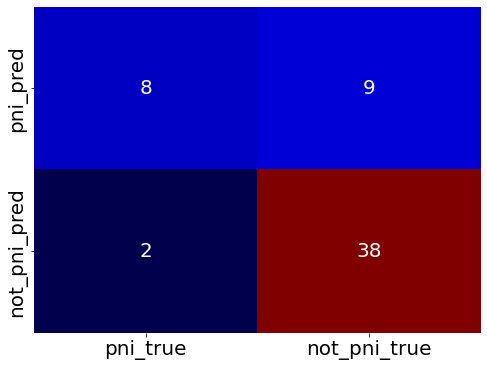

In [16]:
plt.figure(figsize = (8,6))
sns.heatmap(np.array(((tp,fp),(fn,tn))),annot=True,cmap='seismic',fmt='d',cbar=False,annot_kws={'size':20},
            xticklabels=['pni_true','not_pni_true'],
            yticklabels=['pni_pred','not_pni_pred'],
           )


plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
acc = (tp+tn)/(tp+tn+fp+fn)
prec = tp/(tp+fp)
sens = tp/(tp+fn)
spec = tn/(tn+fn)
print(f'Accuracy : {acc:.3f}')
print(f'Precision(PPV) : {prec:.3f}')
print(f'Recall : {recl:.3f}')
print(f'Sensitivity : {sens:.3f}')
print(f'Specficity : {spec:.3f}')